# This notebook uses transfer learning on the pre-trained Inception v3 model to classify mutations in TCGA-LUAD images

## We first define a few locations where results are saved.

In [15]:
import os, sys, json, shutil
from os.path import join
import psutil

cpus = psutil.cpu_count()
#deep_path = join(os.environ["HOME"],'DeepPATH')
deeppath_code = join(os.environ["HOME"],'DeepPATH/DeepPATH_code')
deeppath_data = '/mnt/disks/deeppath-data'
data_base = join(deeppath_data,'Data')
raw_images = join(data_base,'Raw')
data_labels = join(data_base,'data_labels')
#tilings = join(data_base,'tilings')
inception_checkpoints = join(deeppath_data,'inception_checkpoints')

for d in (deeppath_data, data_base, raw_images, inception_checkpoints):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data exists
/mnt/disks/deeppath-data/Data exists
/mnt/disks/deeppath-data/Data/Raw exists
/mnt/disks/deeppath-data/inception_checkpoints exists


In [16]:
# Various GCS buckets and relevant defines
cgc_deeppath_bucket = 'cgc-deeppath' # Bucket containing users credentials
deeppath_data_bucket = 'deeppath-data-whc' # Bucket where results are saved

svs_images_bucket = 'imaging-west'# Bucket containing TCGA pathology images


# Specify tiling parameters
We place results into a tiling specific directory tree. The first five values below control the tiling. Change these to perform a different tiling.

In [17]:
tile_size = 299
overlap = 0
background = 25
magnification = 20
tiling_params = "Px{}Ol{}Bg{}Mg{}_Tile".format(str(tile_size), str(overlap), str(background),str(magnification))
tiling = join(data_base, tiling_params)
tiling_logs = join(tiling,'logs')
# Directory where tiles are stored              
tiles = join(tiling,'tiles')
images_metadata = 'images_metadata.json' # Name of images metadata file  (which will be created below)
images_metadata_path = join(tiling, images_metadata) # Path to images metadata file

for d in (tiling, tiling_logs, tiles):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/tiles exists


# Specify sorting parameter
### Option 10 does not sort into separate groups (directories)

In [18]:
sorting_option = 10
#sortings = join(tiling, 'sortings')

sorting_params = 'So{}Mu{}_Sort'.format(sorting_option,'NonSilent')
sorting = join(tiling, sorting_params)
sorting_logs = join(sorting, 'logs')
sorted_tiles = join(sorting, 'sorted')

mutations_metadata = 'mutations_metadata.txt' # Name of mutation metadata file  (which will be created below)
mutations_metadata_path = join(sorting, mutations_metadata) # Path to metadata file
hugo_symbols_path = join(sorting, 'hugo_symbols.txt')

# Directories where sharded tensor flow formatted records are stored
trainValid_records = join(sorting, 'TFRecord_TrainValid')
test_records = join(sorting, 'TFRecord_Test')
for d in (sorting, sorting_logs, sorted_tiles, trainValid_records, test_records):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/sorted exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_Test exists


# Get metadata from BQ
Rather than obtain metdata from the GDC, we perform an SQL query to obtain the names of LUAD images and mutation metadata. 
### We must first establish credentials. 
See https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries#bigquery_simple_app_query-python for help. Put your credentials in some GCS bucket and modify the "bucket" and "credentials" variables below as necessary

In [12]:
from gcs_access import upload_from_GCS
bucket = 'cgc-deeppath'                                                                                         
credentials = 'GAC.json' 
upload_from_GCS(bucket, credentials, "/tmp/GAC.json")
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/tmp/GAC.json"

Blob GAC.json uploaded to /tmp/GAC.json.


### Now perform a BQ query to get metadata. 
For this purpose, we call query_bq() in which the needed SQL is hardcoded. query_bq() also formats the returned data in the format expected by the tiling and sorting phases.

In [13]:
from get_metadata_from_bq import query_mutation_metadata

sql_query = """
WITH
  luads AS (
  SELECT
    t1.file_gdc_id AS file_gdc_id,
    t1.svsFilename AS svsFilename,
    t1.sample_barcode AS sample_barcode,
    t2.callerName AS callerName,
    t2.Hugo_Symbol AS Hugo_Symbol,
    t2.Variant_Classification AS Variant_Classification
  FROM
    `isb-cgc.metadata.TCGA_slide_images` t1
  INNER JOIN
    `isb-cgc.TCGA_hg38_data_v0.Somatic_Mutation` t2
  ON
    t1.sample_barcode = t2.sample_barcode_tumor
  WHERE
    (t2.project_short_name='TCGA-LUAD')
    AND NOT t1.slide_barcode LIKE '%TCGA-__-____-___-__-D%'),
  mutations AS (
  SELECT
    file_gdc_id,
    svsFilename,
    sample_barcode,
    Hugo_Symbol,
    Variant_Classification
  FROM
    luads
  WHERE
    callerName LIKE '%mutect%'
    AND Hugo_Symbol IN ('EGFR',
      'FAT1',
      'FAT4',
      'KEAP1',
      'KRAS',
      'LRP1B',
      'NF1',
      'SETBP1',
      'STK11',
      'TP53')
    AND Variant_Classification IN ('Missense_Mutation',
      'In_Frame_Del',
      'In_Frame_Ins',
      'Frame_Shift',
      'Frame_Shift_Del',
      'Frame_Shift_Ins',
      'Nonsense_Mutation',
      'Nonstop_Mutation' )),
  wts AS (
  SELECT
    file_gdc_id,
    svsFilename,
    sample_barcode,
    'WT' AS Hugo_Symbol,
    '' AS Variant_Classification
  FROM
    luads
  WHERE
    sample_barcode NOT IN (
    SELECT
      sample_barcode
    FROM
      mutations))
SELECT
  file_gdc_id,
  svsFilename,
  sample_barcode,
  Hugo_Symbol,
  Variant_Classification
FROM
  mutations
UNION DISTINCT
SELECT
  file_gdc_id,
  svsFilename,
  sample_barcode,
  Hugo_Symbol,
  Variant_Classification
FROM
  wts
ORDER BY
  sample_barcode,
  Hugo_Symbol  """

query_mutation_metadata(images_metadata_path, mutations_metadata_path, hugo_symbols_path, sql_query)


# Specify training, validation, test parameters

In [19]:
class_number = !cat $hugo_symbols_path |wc -l # Number of classes
class_number = int(class_number[0])
fine_tune = False # True==Transfer learning, False==Full training

#trainings = join(sorting, "trainings")
training_params = "Cl{}Ft{}_Train".format(str(class_number),str(fine_tune))
training = join(sorting, training_params)
training_logs = join(training, 'logs')
training_mode = '1_sigmoid' # Use sigmoid for multi-class classification

# Directory where intermediate training checkpoints are stored
intermediate_checkpoints = join(training, 'intermediate_checkpoints')
# Directory where validation and test results are stored
eval_results = join(training, 'eval_results')
test_results = join(training, 'test_results')
roc_curves = join(training, 'roc_curves')
heatmaps = join(training,'Px'+str(tile_size))

for d in (training, training_logs, intermediate_checkpoints,
         eval_results, test_results, roc_curves):
  try:
    os.makedirs(d)
  except:
    print("{} exists".format(d))

/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/logs exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/intermediate_checkpoints exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/eval_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/test_results exists
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/Cl10FtFalse_Train/roc_curves exists


# Get/Update DeepPATH code

In [7]:
import os
if not os.path.exists(deeppath_code):
    os.chdir(os.environ["HOME"])
    #!git clone https://github.com/ncoudray/DeepPATH.git
    !git clone -b whc1 https://github.com/bcli4d/DeepPATH.git
else:
    #!git pull https://github.com/ncoudray/DeepPATH.git
    !git -C $deeppath_code pull https://github.com/bcli4d/DeepPATH.git
        
sys.path.insert(0,deeppath_code)

Cloning into 'DeepPATH'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2152 (delta 0), reused 5 (delta 0), pack-reused 2140
Receiving objects: 100% (2152/2152), 1.88 MiB | 0 bytes/s, done.
Resolving deltas: 100% (1266/1266), done.


# Tile the images listed in the manifest
Images are uploaded, on at a time, from GCS and tiled according to parameters

### Optionally load previously saved results from GCS

In [51]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params,'data.tar')
loc = join(tiling,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall()

    !rm $loc
else:
    print('{} not found'.format(loc))

('gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/data.tar.gz', '/mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/data.tar.gz')
Found


## Perform tiling

In [16]:
import json
import shutil
tiler = join(deeppath_code, '00_preprocessing/0b_tileLoop_deepzoom4.py')
out_log_file = join(tiling_logs,'tiler_out.log')
err_log_file = join(tiling_logs,'tiler_err.log')
!rm $out_log_file
!rm $err_log_file
!rm $raw_images/*
skipped_file_name = ""
skipped_file_id = ""
with open(images_metadata_path) as fid:
    jdata = json.loads(fid.read())
    jdata.sort(key = lambda x: x['file_name'])
    for file in jdata:
        print("")
        print("Checking {}".format(file))
        tiled_dziname = join(tiles,file['file_name'].rsplit('.',1)[0]+'.dzi')
        tiled_filesname = join(tiles,file['file_name'].rsplit('.',1)[0]+'_files')
        
        if os.path.exists(tiled_dziname):
            # If the .dzi file exists, then we presume that tiling was completed
            skipped_file_name = file['file_name']
            skipped_file_id = file['file_id']
            print("Skipping {}".format(file['file_name']))
        else:
            print("Processing {}".format(file['file_name']))
            if os.path.exists(tiled_filesname):
                # Apparently this file was only partially tiled, so delete it completely
                print ("removing {}".format(tiled_filesname))
                shutil.rmtree(tiled_filesname)
            GCS_filename = 'gs://'+join(svs_images_bucket,file['file_id'],file['file_name'])
            local_filename = join(raw_images,file['file_name'])
            oldstderr = sys.stderr
            sys.stderr = open(err_log_file, 'a')
            oldstdout = sys.stdout
            sys.stdout = open(out_log_file, 'a')
            !gsutil -m cp $GCS_filename $local_filename
            !python $tiler --output=$tiles --Mag=$magnification \
                --size=$tile_size --overlap=$overlap --Background=$background --jobs=$cpus \
                $raw_images/*svs
            #print("gsutil -m cp {} {}".format(GCS_filename, local_filename))
            !rm $local_filename
            sys.stderr = oldstderr
            sys.stdout = oldstdout


rm: cannot remove '/mnt/disks/deeppath-data/Data/Raw/*': No such file or directory

Checking {u'file_name': u'TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs', u'file_id': u'51c9f202-2185-48bc-b04b-3eeee9279381'}
Skipping TCGA-05-4244-01A-01-BS1.90f043f6-e8d5-4cfd-b4e7-84207bc499a6.svs

Checking {u'file_name': u'TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs', u'file_id': u'4ba49cb2-278f-40e9-8503-7d74d07118c0'}
Skipping TCGA-05-4244-01A-01-TS1.6c46d8c3-d7b4-4513-af31-9170244d60a7.svs

Checking {u'file_name': u'TCGA-05-4249-01A-01-BS1.38c41760-cc43-4904-9575-803d1d92b992.svs', u'file_id': u'99a841da-4967-4221-b26f-c723eaccea91'}
Skipping TCGA-05-4249-01A-01-BS1.38c41760-cc43-4904-9575-803d1d92b992.svs

Checking {u'file_name': u'TCGA-05-4249-01A-01-TS1.912c8d26-dc9f-4bae-bfcd-559cf234c921.svs', u'file_id': u'f8fc4188-15bc-444b-a4c8-cc518292b285'}
Skipping TCGA-05-4249-01A-01-TS1.912c8d26-dc9f-4bae-bfcd-559cf234c921.svs

Checking {u'file_name': u'TCGA-0

Skipping TCGA-38-4625-01A-01-TS1.6fa44ecf-ebe1-4bae-8515-c83eea7b703e.svs

Checking {u'file_name': u'TCGA-38-4626-01A-01-BS1.57181f5e-1b4d-415a-8acc-9dc40dd03f7b.svs', u'file_id': u'f54e7725-1083-4885-98ac-6c764cf6437b'}
Skipping TCGA-38-4626-01A-01-BS1.57181f5e-1b4d-415a-8acc-9dc40dd03f7b.svs

Checking {u'file_name': u'TCGA-38-4626-01A-01-TS1.b856b974-e498-4a8a-a649-bc321c90622a.svs', u'file_id': u'85a02d3d-c639-4dc2-b5b9-8f47f82ed139'}
Skipping TCGA-38-4626-01A-01-TS1.b856b974-e498-4a8a-a649-bc321c90622a.svs

Checking {u'file_name': u'TCGA-38-4627-01A-01-BS1.d141e46d-3eaa-4605-8672-e4341e01bfee.svs', u'file_id': u'5ed8613d-79a8-4735-90f8-417c08228fa9'}
Skipping TCGA-38-4627-01A-01-BS1.d141e46d-3eaa-4605-8672-e4341e01bfee.svs

Checking {u'file_name': u'TCGA-38-4627-01A-01-TS1.221bb9bb-9a72-4f33-89c1-d07eb422112e.svs', u'file_id': u'b5c8df0e-5c60-4cd3-a463-61d58014ef29'}
Skipping TCGA-38-4627-01A-01-TS1.221bb9bb-9a72-4f33-89c1-d07eb422112e.svs

Checking {u'file_name': u'TCGA-38-4628-01

Skipping TCGA-55-1596-01A-01-BS1.3bc1baf3-00ab-4b9c-bf3c-c49acab55d09.svs

Checking {u'file_name': u'TCGA-55-1596-01A-01-TS1.7362d5c7-8651-4ac7-8760-613fdc4f2a70.svs', u'file_id': u'8ba415fb-4e8d-43d6-b0c9-850e4d758696'}
Skipping TCGA-55-1596-01A-01-TS1.7362d5c7-8651-4ac7-8760-613fdc4f2a70.svs

Checking {u'file_name': u'TCGA-55-5899-01A-01-TS1.cc1d9936-fc06-46a0-83c6-8afe05723f06.svs', u'file_id': u'4dc0ec3d-084d-4d9e-9cea-f485710c72ed'}
Skipping TCGA-55-5899-01A-01-TS1.cc1d9936-fc06-46a0-83c6-8afe05723f06.svs

Checking {u'file_name': u'TCGA-55-6543-01A-01-BS1.9056c6b4-b8bc-4f5e-8e5d-fb8aedafc0d7.svs', u'file_id': u'b1abafd0-252e-46b2-86ca-f1f9702e6a1b'}
Skipping TCGA-55-6543-01A-01-BS1.9056c6b4-b8bc-4f5e-8e5d-fb8aedafc0d7.svs

Checking {u'file_name': u'TCGA-55-6543-01A-01-TS1.610c1bda-86df-4f39-8621-ef0228f25ad1.svs', u'file_id': u'592a57e1-c674-417d-a045-46048da2c9ef'}
Skipping TCGA-55-6543-01A-01-TS1.610c1bda-86df-4f39-8621-ef0228f25ad1.svs

Checking {u'file_name': u'TCGA-55-6642-01

Skipping TCGA-86-7713-01A-01-BS1.e99156ce-4f80-4837-8ca6-4f7b4019a750.svs

Checking {u'file_name': u'TCGA-86-7713-01A-01-TS1.40cec003-0322-413e-8544-6fd916d9ee0c.svs', u'file_id': u'abc9e42a-d3f5-46f9-8ccf-42349938c105'}
Skipping TCGA-86-7713-01A-01-TS1.40cec003-0322-413e-8544-6fd916d9ee0c.svs

Checking {u'file_name': u'TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d.svs', u'file_id': u'094e9057-4b63-49da-a323-0981ce42fba5'}
Skipping TCGA-86-7714-01A-01-BS1.96ae5077-ba6a-47e1-893d-63e0bcea734d.svs

Checking {u'file_name': u'TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045.svs', u'file_id': u'e8968470-06eb-48f2-8e14-0cc75fb9df27'}
Skipping TCGA-86-7714-01A-01-TS1.459126fb-76b3-41d3-8a00-c575e3342045.svs

Checking {u'file_name': u'TCGA-86-7953-01A-01-BS1.12a70470-317a-4a67-a853-dc5f7e3f673c.svs', u'file_id': u'e9e29865-ca65-450d-a775-53d25d83f152'}
Skipping TCGA-86-7953-01A-01-BS1.12a70470-317a-4a67-a853-dc5f7e3f673c.svs

Checking {u'file_name': u'TCGA-86-7953-01

### Optionally save tiling results to GCS

In [5]:
import tarfile

# Populate the tar file. Don't try to compress.
loc = join(tiling,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [tiles, tiling_logs]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params,'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

Copying file:///mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/data.tar.gz [Content-Type=application/x-tar]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/ [1/1 files][ 30.9 GiB/ 30.9 GiB] 100% Done  84.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/30.9 GiB.                                     


# Sort tiles


### Optionally load previously saved sorting results from GCS

In [67]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, 'data.tar.gz')
loc = join(sorting,'data.tar.gz')

result = !gsutil ls $gcs
if result[0] == gcs:
    !gsutil -m cp $gcs $loc 
    
    !ls -l $loc
    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

Copying gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz...
\ [1/1 files][  5.8 GiB/  5.8 GiB] 100% Done  73.8 MiB/s ETA 00:00:00           
Operation completed over 1 objects/5.8 GiB.                                      
-rw-r--r-- 1 bcliffor bcliffor 6178730916 Apr 22 19:58 /mnt/disks/deeppath-data/Data/Px512Ol0Bg25Mg5_Tile/So3_Sort/data.tar.gz


## Perform the sort

In [17]:
# The sort routine outputs to the cwd. So change cwd as needed.
# First, remove existing sort results
try:
    shutil.rmtree(sorted_tiles)
except:
    pass
os.mkdir(sorted_tiles)
cwd = os.getcwd()
os.chdir(sorted_tiles)

func = join(deeppath_code,'00_preprocessing/0d_SortTiles.py' )
root = func.rsplit('/',1)[1].split('.')[0]

out_log_file = join(sorting_logs,root+'.out.log')
err_log_file = join(sorting_logs,root+'.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

%xmode Verbose

try:
    !python $func --SourceFolder=$tiles --JsonFile=$images_metadata_path --PercentValid=15 --PercentTest=15 \
        --PatientID=12 --Magnification=$magnification --MagDiffAllowed=0.0 --SortingOption=$sorting_option --nSplit=0
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout
    os.chdir(cwd)


# Convert the JPEG tiles into TFRecord format for the multiple mutations
## First format the training and validation data

In [7]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(trainValid_records)
except:
    pass
os.mkdir(trainValid_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_image_data_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.train.out.log')
err_log_file = join(sorting_logs,root+'.train.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$trainValid_records --train_shards=1024 \
        --validation_shards=128 --num_threads=$cpus  --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Now format the test data

In [8]:
# Remove existing TFRecord conversion results
try:
    shutil.rmtree(test_records)
except:
    pass
os.mkdir(test_records)

func = join(deeppath_code,'00_preprocessing/TFRecord_multi_Classes/build_TF_test_multiClass.py' )
root = func.rsplit('/',1)[1].split('.')[0]
out_log_file = join(sorting_logs,root+'.test.out.log')
err_log_file = join(sorting_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

try:
    !python $func --directory=$sorted_tiles/tiles --output_directory=$test_records --train_shards=1024 \
        --validation_shards=128 --num_threads=$cpus --one_FT_per_Tile=False --ImageSet_basename='test' \
        --labels_names=$hugo_symbols_path --labels=$mutations_metadata_path \
        --PatientID=12
except:
    pass
finally:
    sys.stderr = oldstderr
    sys.stdout = oldstdout


## Optionally save sorting results to GCS

In [ ]:
import tarfile

# Populate the tar file
loc = join(sorting,'data.tar')
with tarfile.open(loc, "w") as tar:
    #for name in [sorting_logs, sorted_tiles, trainValid_records, test_records]:
    for name in [trainValid_records, test_records]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

# Training

## Optionally load previously saved training results from GCS

In [70]:
import tarfile
gcs = join('gs://', deeppath_data_bucket, tiling_params, sorting_params, training_params, 'data.tar')
loc = join(training,'data.tar')

result = !gsutil ls $gcs
if result[0] ==gcs:
    !gsutil -m cp $gcs $loc 

    with tarfile.open(loc) as tar:
        tar.extractall('/')

    !rm $loc
else:
    print('{} not found'.format(gcs))

gs://deeppath-data-whc/Px512Ol0Bg25Mg5_Tile/So3_Sort/Cl3FtTrue_Train/data.tar.gz not found


## We first have to install the Bazel build tool

In [ ]:
!sudo apt-get install -y pkg-config zip g++ zlib1g-dev unzip python
!wget https://github.com/bazelbuild/bazel/releases/download/0.24.0/bazel-0.24.0-installer-linux-x86_64.sh
!chmod +x bazel-0.24.0-installer-linux-x86_64.sh
!./bazel-0.24.0-installer-linux-x86_64.sh --user
os.environ["PATH"] += ":" + join(os.getcwd(),'bin')
!rm bazel-0.24.0-installer-linux-x86_64.sh


## Next build the Inception model

In [ ]:
#os.chdir(join(os.environ["HOME"],'DeepPATH/DeepPATH_code/s01_training/xClasses'))
cwd = os.getcwd()
os.chdir(join(deeppath_code,'01_training/xClasses'))
print(os.getcwd())
!bazel build inception/imagenet_train


 ## Fully train the model

In [ ]:
function = join(deeppath_code,'01_training/xClasses/bazel-bin/inception/imagenet_train' )
root = function.rsplit('/',1)[1]
# Note that the --train_dir directory appears to be deleted and recreated
!python $function \
    --num_gpus=1 --batch_size=30 --train_dir=$intermediate_checkpoints --data_dir=$trainValid_records \
    --ClassNumber=$class_number --mode=$training_mode

!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Colocations handled automatically by placer.
!!!!!!!!!!!!!!
/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10MuNonSilent_Sort/TFRecord_TrainValid/train-*
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for u

2019-05-28 18:31:44.356982: step 60, loss = 4.00 (23.2 examples/sec; 1.294 sec/batch)
2019-05-28 18:31:57.457636: step 70, loss = 4.02 (22.7 examples/sec; 1.320 sec/batch)
2019-05-28 18:32:10.615850: step 80, loss = 3.98 (23.6 examples/sec; 1.273 sec/batch)
2019-05-28 18:32:23.616800: step 90, loss = 3.97 (22.6 examples/sec; 1.329 sec/batch)
2019-05-28 18:32:36.790313: step 100, loss = 3.99 (22.5 examples/sec; 1.331 sec/batch)
2019-05-28 18:32:58.484849: step 110, loss = 3.95 (22.6 examples/sec; 1.325 sec/batch)
2019-05-28 18:33:11.362026: step 120, loss = 3.89 (23.8 examples/sec; 1.262 sec/batch)
2019-05-28 18:33:24.381684: step 130, loss = 4.03 (23.6 examples/sec; 1.274 sec/batch)
2019-05-28 18:33:37.448528: step 140, loss = 3.92 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 18:33:50.510754: step 150, loss = 4.05 (23.5 examples/sec; 1.279 sec/batch)
2019-05-28 18:34:03.652366: step 160, loss = 3.91 (23.3 examples/sec; 1.288 sec/batch)
2019-05-28 18:34:16.705417: step 170, loss = 3.

2019-05-28 18:53:47.555365: step 1010, loss = 3.79 (23.8 examples/sec; 1.258 sec/batch)
2019-05-28 18:54:00.526058: step 1020, loss = 3.73 (23.9 examples/sec; 1.254 sec/batch)
2019-05-28 18:54:13.704366: step 1030, loss = 3.68 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 18:54:26.692521: step 1040, loss = 3.70 (22.8 examples/sec; 1.317 sec/batch)
2019-05-28 18:54:39.743428: step 1050, loss = 3.67 (23.6 examples/sec; 1.272 sec/batch)
2019-05-28 18:54:52.837425: step 1060, loss = 3.72 (23.8 examples/sec; 1.258 sec/batch)
2019-05-28 18:55:05.953214: step 1070, loss = 3.68 (22.8 examples/sec; 1.317 sec/batch)
2019-05-28 18:55:18.993322: step 1080, loss = 3.61 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 18:55:32.006793: step 1090, loss = 3.73 (22.9 examples/sec; 1.311 sec/batch)
2019-05-28 18:55:45.159127: step 1100, loss = 3.75 (22.7 examples/sec; 1.321 sec/batch)
2019-05-28 18:56:06.480475: step 1110, loss = 3.67 (23.1 examples/sec; 1.296 sec/batch)
2019-05-28 18:56:19.413676: step

2019-05-28 19:15:27.661701: step 1950, loss = 3.50 (22.6 examples/sec; 1.326 sec/batch)
2019-05-28 19:15:40.744959: step 1960, loss = 3.38 (22.6 examples/sec; 1.325 sec/batch)
2019-05-28 19:15:53.763590: step 1970, loss = 3.44 (23.1 examples/sec; 1.298 sec/batch)
2019-05-28 19:16:06.866307: step 1980, loss = 3.54 (23.2 examples/sec; 1.295 sec/batch)
2019-05-28 19:16:19.911163: step 1990, loss = 3.46 (22.4 examples/sec; 1.339 sec/batch)
2019-05-28 19:16:32.949648: step 2000, loss = 3.47 (23.3 examples/sec; 1.290 sec/batch)
2019-05-28 19:16:54.123932: step 2010, loss = 3.44 (22.6 examples/sec; 1.330 sec/batch)
2019-05-28 19:17:07.081759: step 2020, loss = 3.40 (23.5 examples/sec; 1.275 sec/batch)
2019-05-28 19:17:20.134574: step 2030, loss = 3.44 (23.2 examples/sec; 1.291 sec/batch)
2019-05-28 19:17:33.050506: step 2040, loss = 3.49 (23.4 examples/sec; 1.282 sec/batch)
2019-05-28 19:17:46.071779: step 2050, loss = 3.44 (22.6 examples/sec; 1.330 sec/batch)
2019-05-28 19:17:59.164866: step

2019-05-28 19:37:09.730187: step 2890, loss = 3.26 (23.3 examples/sec; 1.287 sec/batch)
2019-05-28 19:37:22.897614: step 2900, loss = 3.35 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 19:37:44.092018: step 2910, loss = 3.23 (23.9 examples/sec; 1.256 sec/batch)
2019-05-28 19:37:57.108936: step 2920, loss = 3.23 (23.2 examples/sec; 1.291 sec/batch)
2019-05-28 19:38:10.172264: step 2930, loss = 3.25 (23.4 examples/sec; 1.283 sec/batch)
2019-05-28 19:38:23.229046: step 2940, loss = 3.23 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 19:38:36.225301: step 2950, loss = 3.21 (23.5 examples/sec; 1.277 sec/batch)
2019-05-28 19:38:49.295453: step 2960, loss = 3.25 (23.6 examples/sec; 1.272 sec/batch)
2019-05-28 19:39:02.451063: step 2970, loss = 3.19 (23.5 examples/sec; 1.275 sec/batch)
2019-05-28 19:39:15.483602: step 2980, loss = 3.24 (23.1 examples/sec; 1.299 sec/batch)
2019-05-28 19:39:28.492318: step 2990, loss = 3.29 (22.6 examples/sec; 1.327 sec/batch)
2019-05-28 19:39:41.535676: step

2019-05-28 19:58:59.244027: step 3830, loss = 3.06 (23.5 examples/sec; 1.277 sec/batch)
2019-05-28 19:59:12.405548: step 3840, loss = 3.02 (22.5 examples/sec; 1.335 sec/batch)
2019-05-28 19:59:25.583999: step 3850, loss = 3.06 (22.7 examples/sec; 1.321 sec/batch)
2019-05-28 19:59:38.636863: step 3860, loss = 3.10 (22.3 examples/sec; 1.346 sec/batch)
2019-05-28 19:59:51.605827: step 3870, loss = 3.07 (23.4 examples/sec; 1.284 sec/batch)
2019-05-28 20:00:04.682889: step 3880, loss = 3.03 (22.8 examples/sec; 1.318 sec/batch)
2019-05-28 20:00:17.688721: step 3890, loss = 3.11 (22.3 examples/sec; 1.346 sec/batch)
2019-05-28 20:00:30.680912: step 3900, loss = 3.04 (23.7 examples/sec; 1.264 sec/batch)
2019-05-28 20:00:51.853633: step 3910, loss = 3.06 (22.5 examples/sec; 1.331 sec/batch)
2019-05-28 20:01:04.897349: step 3920, loss = 3.07 (22.5 examples/sec; 1.336 sec/batch)
2019-05-28 20:01:17.942925: step 3930, loss = 3.02 (23.6 examples/sec; 1.271 sec/batch)
2019-05-28 20:01:31.097453: step

2019-05-28 20:20:39.177333: step 4770, loss = 2.92 (23.1 examples/sec; 1.298 sec/batch)
2019-05-28 20:20:52.358401: step 4780, loss = 2.91 (22.9 examples/sec; 1.310 sec/batch)
2019-05-28 20:21:05.560889: step 4790, loss = 2.90 (22.8 examples/sec; 1.315 sec/batch)
2019-05-28 20:21:18.581208: step 4800, loss = 2.87 (22.6 examples/sec; 1.327 sec/batch)
2019-05-28 20:21:39.920056: step 4810, loss = 2.86 (23.0 examples/sec; 1.305 sec/batch)
2019-05-28 20:21:52.910872: step 4820, loss = 2.82 (22.3 examples/sec; 1.342 sec/batch)
2019-05-28 20:22:06.058029: step 4830, loss = 2.90 (22.5 examples/sec; 1.334 sec/batch)
2019-05-28 20:22:19.280149: step 4840, loss = 2.82 (22.3 examples/sec; 1.345 sec/batch)
2019-05-28 20:22:32.640773: step 4850, loss = 2.89 (22.1 examples/sec; 1.355 sec/batch)
2019-05-28 20:22:45.720034: step 4860, loss = 2.84 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 20:22:58.769432: step 4870, loss = 2.86 (22.7 examples/sec; 1.324 sec/batch)
2019-05-28 20:23:11.758711: step

2019-05-28 20:42:35.890089: step 5710, loss = 2.70 (23.5 examples/sec; 1.274 sec/batch)
2019-05-28 20:42:48.910114: step 5720, loss = 2.70 (22.7 examples/sec; 1.322 sec/batch)
2019-05-28 20:43:01.879287: step 5730, loss = 2.68 (23.7 examples/sec; 1.268 sec/batch)
2019-05-28 20:43:14.851305: step 5740, loss = 2.72 (23.3 examples/sec; 1.287 sec/batch)
2019-05-28 20:43:27.740682: step 5750, loss = 2.67 (23.1 examples/sec; 1.300 sec/batch)
2019-05-28 20:43:40.737875: step 5760, loss = 2.70 (23.1 examples/sec; 1.297 sec/batch)
2019-05-28 20:44:52.973416: step 5810, loss = 2.75 (23.2 examples/sec; 1.292 sec/batch)
2019-05-28 20:45:05.800031: step 5820, loss = 2.62 (23.4 examples/sec; 1.280 sec/batch)
2019-05-28 20:45:18.848518: step 5830, loss = 2.70 (22.9 examples/sec; 1.308 sec/batch)
2019-05-28 20:45:31.765731: step 5840, loss = 2.68 (23.8 examples/sec; 1.261 sec/batch)
2019-05-28 20:45:44.698112: step 5850, loss = 2.62 (22.4 examples/sec; 1.337 sec/batch)
2019-05-28 20:45:57.687257: step

# Validation
Validation is ideally performed while training is in progress to help decide when sufficient training has been performed. On Jupyter we can't run training and validation concurrently, and so have to stop training in order to validate, then do more training if needed.

In [ ]:

# Training checkpoints every 5000 batches. The training_checkpoint parameter to eval_all.sh controls which
# checkpoints are validated:
# -1: Validate the maximal checkpoint
# n*5000, n>=0: Validate all checkpoints from n*5000
# 

training_count = -1
try:
    shutil.rmtree(eval_results)
except:
    pass
os.mkdir(eval_results)

eval = join(os.environ["HOME"],'jupyter_DeepPATH','eval_all.sh')
!$eval \
    $intermediate_checkpoints $eval_results $trainValid_records $hugo_symbols_path \
    $deeppath_code/02_testing/xClasses/nc_imagenet_eval.py \
    $deeppath_code/03_postprocessing/0h_ROC_MultiOutput_BootStrap.py $training_logs $training_mode $training_count $class_number 

In [ ]:
hugo_symbols_path

# Test

In [8]:
try:
    shutil.rmtree(test_results)
except:
    pass
os.mkdir(test_results)

function = join(deeppath_code,'02_testing/xClasses/nc_imagenet_eval.py' )
root = function.rsplit('/',1)[1].split('.')[0]

#Redirect output because Jupyter has a limit on test output
out_log_file = join(training_logs,root+'.test.out.log')
err_log_file = join(training_logs,root+'.test.err.log')
oldstderr = sys.stderr
sys.stderr = open(err_log_file, 'w')
oldstdout = sys.stdout
sys.stdout = open(out_log_file, 'w')

!python $function --checkpoint_dir=$intermediate_checkpoints --eval_dir=$test_results \
    --data_dir=$test_records
  --batch_size 30 --ImageSet_basename='test_' --run_once --ClassNumber=$class_number \
    --mode=$training_mode --TVmode='test'

sys.stderr = oldstderr
sys.stdout = oldstdout



# Analyze results
The following generates heatmaps for specified slides.

In [ ]:
function = join(deeppath_code,'03_postprocessing/0f_HeatMap_nClasses.py' )
root = function.rsplit('/',1)[1].split('.')[0]
try:
    shutil.rmtree(heatmaps)
except:
    pass
os.mkdir(heatmaps)


try:
    os.mkdir(output)
except:
    pass

tile_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --image_file=$sorted_tiles --tiles_overlap 0 --output_dir=$heatmaps \
    --tiles_stats=$tile_stats --resample_factor 10  --filter_tile '' \
    --Cmap 'CancerType' --tiles_size $tile_size



In [10]:
from IPython.display import Image


In [ ]:
Image("/home/bcliffor/tmp/j2.jpg")

In [ ]:
Image(join(tiling, 
  'px299/heatmaps/heatmap_CancerType_test_TCGA-NC-A5HR-01A-02-TS2.1B2A21A9-E685-461D-A3FF-42A0D9D7FC23_TCGA-LUSC.jpg'))



# Generate ROC curve data

In [9]:
try:
    os.mkdir(roc_curves)
except:
    pass

function = join(deeppath_code, '03_postprocessing/0h_ROC_MultiOutput_BootStrap.py')
root = function.rsplit('/',1)[1].split('.')[0]

file_stats = join(test_results, 'out_filename_Stats.txt')
!python $function  --file_stats=$file_stats --output_dir=$roc_curves  --labels_names=$hugo_symbols_path \
    --ref_stats=''



DEBUG:
123907
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
123907
[[0.12360078 0.45603293 0.27976966 ... 0.14261308 0.13428485 0.624903  ]
 [0.22959703 0.04028478 0.13573992 ... 0.01772705 0.27107644 0.28194022]
 [0.16719195 0.08152965 0.44461897 ... 0.05313322 0.02481815 0.29360414]
 ...
 [0.03063962 0.16208029 0.02026311 ... 0.00974926 0.5687011  0.04259276]
 [0.00869015 0.179678   0.01802507 ... 0.01322573 0.61355925 0.00470623]
 [0.0341638  0.7314836  0.03733882 ... 0.00669071 0.8765054  0.04443452]]
123907
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[0. 0. 0. ... 0. 0. 0.] [0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ] [0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.12360078 0.22959703 0.16719195 ... 0.03063962 0.00869015 0.0341638 ]


******* FP / TP for percent selected
{0: array([0.        , 0.07286633, 1.        ]), 1: array([0.        , 0.04138929, 1.        ]), 2: array([0.        , 0.04305948, 1.        ]), 3: array([0.        , 0.02945579, 1.        ]), 4: array([0.        , 0.11603728, 1.        ]), 5: array([0.        , 0.19442071, 1.        ]), 6: array([0.        , 0.02422228, 1.        ]), 7: array([0.        , 0.01877223, 1.        ]), 8: array([0.        , 0.03504968, 1.        ]), 9: array([0.        , 0.39781884, 1.        ]), 'macro': array([0.        , 0.01877223, 0.02422228, 0.02945579, 0.03504968,
       0.04138929, 0.04305948, 0.07286633, 0.11603728, 0.19442071,
       0.39781884, 1.        ]), 'micro': array([0.        , 0.07897091, 1.        ])}
{0: array([0.        , 0.11243345, 1.        ]), 1: array([0.        , 0.01221964, 1.        ]), 2: array([0.        , 0.06487793, 1.        ]), 3: array([0.        , 0.03393576, 1.        ]), 4: array([0.        , 0.09633477, 1.        ]), 5: array([0

0.346031746031746
0.6231435643564356
Confidence interval for the score: [0.346 - 0.623]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.20650883 0.09150949 0.33132609 0.09019743 0.12375225 0.26627027
 0.1508883  0.36613784 0.06301545 0.12371436 0.30976267 0.16367999
 0.15288538 0.15788587 0.18492072 0.23478542 0.65657749 0.27147274
 0.06962692 0.1569554  0.36758215 0.09596379 0.27092627 0.01771367
 0.15168449 0.23924101 0.23879938 0.07830307 0.31124176 0.18209437
 0.19023226 0.1750389  0.16009734 0.1765595  0.26955736 0.11822071
 0.09730593 0.13339286 0.14163945 0.31464062 0.2442975  0.30955705
 0.01220315 0.21736151 0.13334568 0.12375701 0.13076075 0.3385259
 0.13056945 0.102908

0.39173913043478265
0.6729879740980573
Confidence interval for the score: [0.392 - 0.673]
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
[0.12121212 0.10047847 0.06329114 0.35491071 0.04285714 0.03167421
 0.09443099 0.07853637 0.06031746 0.16346154 0.00623269 0.01923077
 0.23397762 0.22884882 0.18612818 0.02476516 0.02560647 0.12082671
 0.66873449 0.30769231 0.0015748  0.00177462 0.06603774 0.00126422
 0.01410935 0.02403846 0.21428571 0.56730769 0.32102273 0.23060109
 0.04795991 0.35154394 0.03295455 0.04548387 0.         0.51977401
 0.28409091 0.02766798 0.21061947 0.01818629 0.02411765 0.09090909
 0.00381316 0.12132353 0.06770833 0.14516129 0.15384615 0.04689864
 0.01257862 0.090

0.4014336917562724
0.6794258373205742
Confidence interval for the score: [0.401 - 0.679]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0.12201863 0.03404547 0.35480504 0.12670434 0.03025061 0.10947427
 0.10288379 0.01842884 0.02786264 0.07867705 0.04479572 0.04540278
 0.08335484 0.02727605 0.1130535  0.439397   0.03125061 0.31017346
 0.23615088 0.16247722 0.16968008 0.11905526 0.13274846 0.00918072
 0.04196566 0.10418805 0.06162455 0.12283204 0.01520883 0.0084075
 0.10503008 0.03544306 0.0613114  0.07083667 0.05119744 0.1122107
 0.01046987 0.1236725  0.07481319 0.10526616 0.09661186 0.16802033
 0.01714818 0.23130913 0.03694158 0.12390181 0.01723303 0.49109287
 0.05831394 0.103694

0.4213909994155465
0.6338398597311513
Confidence interval for the score: [0.421 - 0.634]
[1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
[0.66666667 0.32535885 0.36708861 0.37946429 0.22857143 0.58823529
 0.54237288 0.43105756 0.11746032 0.64615385 0.7465374  0.67307692
 0.29399797 0.18862691 0.48200176 0.43296328 0.34770889 0.50874404
 0.05252275 0.35502959 0.78740157 0.63176575 0.37735849 0.00758534
 0.05878895 0.6328125  0.60714286 0.15384615 0.65056818 0.25027322
 0.18396564 0.5023753  0.81477273 0.55516129 0.77005348 0.29039548
 0.23863636 0.75889328 0.48318584 0.5930204  0.58411765 0.33766234
 0.02097235 0.14926471 0.80208333 0.66129032 0.38461538 0.10892587
 0.35974843 0.2256

{0: array([0.        , 0.00980392, 0.00980392, 0.01960784, 0.01960784,
       0.02941176, 0.02941176, 0.08823529, 0.08823529, 0.19607843,
       0.19607843, 0.33333333, 0.33333333, 0.34313725, 0.34313725,
       0.45098039, 0.45098039, 0.50980392, 0.50980392, 0.74509804,
       0.74509804, 0.81372549, 0.81372549, 0.83333333, 1.        ]), 1: array([0.        , 0.01041667, 0.02083333, 0.02083333, 0.08333333,
       0.08333333, 0.125     , 0.125     , 0.23958333, 0.23958333,
       0.3125    , 0.3125    , 0.33333333, 0.33333333, 0.42708333,
       0.42708333, 0.47916667, 0.47916667, 0.57291667, 0.57291667,
       0.70833333, 1.        ]), 2: array([0.        , 0.01123596, 0.02247191, 0.02247191, 0.07865169,
       0.07865169, 0.08988764, 0.08988764, 0.11235955, 0.11235955,
       0.15730337, 0.15730337, 0.20224719, 0.20224719, 0.21348315,
       0.2247191 , 0.3258427 , 0.3258427 , 0.33707865, 0.33707865,
       0.37078652, 0.37078652, 0.41573034, 0.41573034, 0.43820225,
       0.43820225

## Optionally save training results to GCS

In [7]:
import tarfile

# Populate the tar file
# Note we don't save validation results.
loc = join(training,'data.tar')
with tarfile.open(loc, "w") as tar:
    for name in [intermediate_checkpoints, training_logs,  roc_curves,  test_results, heatmaps]:
        tar.add(name)

# Copy it to GCS
gcs = join('gs://', deeppath_data_bucket,tiling_params, sorting_params, training_params, 'data.tar')
!gsutil -m cp $loc $gcs 

# Delete the tar file
!rm $loc

OSError: [Errno 2] No such file or directory: '/mnt/disks/deeppath-data/Data/Px299Ol0Bg25Mg20_Tile/So10_Sort/Cl10FtFalse_Train/Px299'

# Display ROC Curves

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
lw=2
def draw_rocs(roc_base):
    plt.figure()
    #colors = cycle(['deeppink', 'navy', 'aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['deeppink', 'navy', 'C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'])
    lws = [4, 4, 2, 2, 2, 2, 2, 2 ,2 ,2 ,2 ,2]
    curves = ['micro', 'macro', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
    linestyles = [':', ':', '-', '-', '-', '-', '-', '-', '-', '-', '-']
    for curve, color, lw, linestyle in zip(curves, colors, lws, linestyles):
        f = [x for x in os.listdir(roc_curves) if x.find(roc_base + curve)==0][0]
        lines = np.loadtxt(join(roc_curves,f), comments="#", delimiter="\t", unpack=True)
        plt.plot(lines[0], lines[1], color = color, lw=lw, linestyle=linestyle,
             label = '{0} ROC curve (area = {1:0.2f})'.format(curve,float(f[f.find('auc_')+4:f.find('auc_')+10])))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


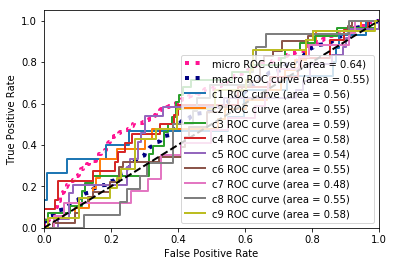

In [18]:
roc_base = 'out2_roc_data_AvPb_'
draw_rocs(roc_base)



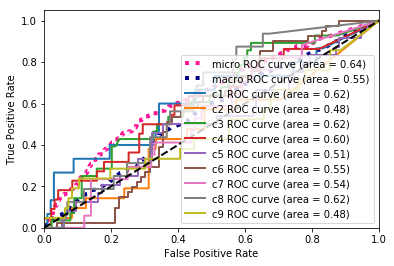

In [19]:
roc_base = 'out2_roc_data_PcSel_'
draw_rocs(roc_base)
